# **CS 722 Machine Learning Project**

### **Name : Sai Kiran Sangam**

### **UIN : 01184212**

### **Project Title : Self-training with noisy student improves ImageNet classification.**

**Abstract**: Noisy student training, a semi-supervised learning approach. It extends the idea of self-training and distillation with the use of equal-or-larger student models and noise added to the student during learning. Noisy student training achieves 88.4% top-1 accuracy on ImageNet, which is 2.0% better than the state-of-the-art model that requires labeled instagram images. This approach not only surpasses the top1 ImageNet accuracy of SOTA models by 1%, its robustness of a model also improves.


**Introduction** : Deep learning has shown remarkable successes in image recognition in recent years. However state-of -art vision models are still trained with supervised learning which requires a large corpus of labeled images to work well. In this project I'm using unlabeled images to improve the SOTA ImageNet accuracy. Training the model using a self-training framework which has three main steps: Train a teacher model on labeled images, use the teacher to generate pseudo labels on unlabeled images and train a student model on the combination of labeled images and pseudo labeled images. Noisy Student Training seeks to improve on self-training and distillation in two ways. First, it makes the student larger than, or at least equal to, the teacher so the student can better learn from a larger dataset. Second, it adds noise to the student so the noised student is forced to learn harder from the pseudo labels. To noise the student, it uses input noise such as RandAugment data augmentation, and model noise such as dropout and stochastic depth during training.



## **Self-training with noisy student improves imagenet classification**

Noisy Student Training, a semi-supervised learning approach that works well even when labeled data is abundant. Noisy Student Training achieves 88.4% top-1 accuracy on ImageNet, which is 2.0% better than the state-of-the-art model that requires 3.5B weakly labeled Instagram images. On robustness test sets, it improves ImageNet-A top-1 accuracy from 61.0% to 83.7%, reduces ImageNet-C mean corruption error from 45.7 to 28.3, and reduces ImageNet-P mean flip rate from 27.8 to 12.2.

Noisy Student Training extends the idea of self-training and distillation with the use of equal-or-larger student models and noise added to the student during learning. On ImageNet, we first train an EfficientNet model on labeled images and use it as a teacher to generate pseudo labels for 300M unlabeled images. We then train a larger EfficientNet as a student model on the combination of labeled and pseudo labeled images. We iterate this process by putting back the student as the teacher. During the learning of the student, we inject noise such as dropout, stochastic depth, and data augmentation via RandAugment to the student so that the student generalizes better than the teacher. 

Self-training with Noisy Student improves ImageNet classification (https://arxiv.org/pdf/1911.04252.pdf) achives 88.4% on the ImageNet.


# Noisy Student Efficientnet models


changes:
- uses the efficientnet keras implementation 
- loading noisy-student models

In [ ]:
!pip install efficientnet

     |████████████████████████████████| 50 kB 1.5 MB/s 


In [ ]:
#import libraries
import os
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import glob
import shutil
sys.path.append('..')
from IPython.display import Image

User_tfKeras = False

In [ ]:
if User_tfKeras:
    from tensorflow.keras import models
    from tensorflow.keras import layers
    from tensorflow.keras import optimizers

    from efficientnet.tfkeras import EfficientNetB6
    from efficientnet.tfkeras import EfficientNetL2
    from efficientnet.tfkeras import center_crop_and_resize, preprocess_input
else:
    from keras import models
    from keras import layers
    from keras import optimizers

    from efficientnet.keras import EfficientNetB6
    from efficientnet.keras import EfficientNetL2
    from efficientnet.keras import center_crop_and_resize, preprocess_input

In [ ]:
batch_size = 48

width = 150
height = 150
epochs = 500
NUM_TRAIN = 2000
NUM_TEST = 1000
dropout_rate = 0.2
input_shape = (height, width, 3)

## Prepare dataset

In [ ]:
#loading dataset
if not os.path.isfile("kagglecatsanddogs_3367a.zip"):
  !wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
  !unzip -qq kagglecatsanddogs_3367a.zip -d dog_vs_cat
else:
  print("dataset already exist.")

--2021-12-09 18:14:31--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.27.220.188, 2600:1407:3c00:108c::e59, 2600:1407:3c00:10a2::e59
Connecting to download.microsoft.com (download.microsoft.com)|184.27.220.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M   121MB/s    in 6.4s    

2021-12-09 18:14:38 (123 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]



In [ ]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = './dog_vs_cat/PetImages'

cat_images = glob.glob(os.path.join(original_dataset_dir, "Cat", '*.jpg'))
dog_images = glob.glob(os.path.join(original_dataset_dir, "Dog", '*.jpg'))
print("total cat images: {}\n\rtotal dog images: {}".format(len(cat_images), len(dog_images)))

total cat images: 12500
total dog images: 12500


In [ ]:
# The directory where we will
# store our smaller dataset
base_dir = './data/dog_vs_cat_small'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.makedirs(train_cats_dir, exist_ok=True)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.makedirs(train_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.makedirs(validation_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.makedirs(validation_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.makedirs(test_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.makedirs(test_dogs_dir, exist_ok=True)

# Copy first NUM_TRAIN//2 cat images to train_cats_dir
fnames = cat_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST //2 cat images to validation_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2
# Copy next NUM_TRAIN//2 cat images to test_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


# Copy first NUM_TRAIN//2 dog images to train_dogs_dir
fnames = dog_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST // 2 dog images to validation_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2

# Copy next NUM_TEST // 2 dog images to test_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


### **Noisy Student**

Noisy student training Labeled images {(x1, y1),(x2, y2), ...,(xn, yn)} and unlabeled images {x˜1, x˜2, ..., x˜m}. 
1. Learn teacher model ✓ t ∗ which minimizes the cross entropy loss on labeled images 1/n Xn i=1 `(yi, f noised(xi, ✓ t )).
2. Use an unnoised teacher model to generate soft or hard pseudo labels for unlabeled images y˜i = f(˜xi, ✓ t ∗), ∀i = 1, ··· , m.
3. Learn an equal-or-larger student model ✓ s ∗ which minimizes the cross entropy loss on labeled images and unlabeled images with noise added to the student model 1 n Xn i=1 `(yi, f noised(xi, ✓ s )) + 1 m Xm i=1 `(˜yi, f noised(˜xi, ✓ s )) .
4. Iterative training: Use the student as a teacher and go back to step 2.


## Prepare DataGenerators

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=batch_size,
        # use categorical_crossentropy loss,  need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Load efficientnet model and add final dense layer
The model are loaded with pretrained weights, final dense layer is added for the cat vs. dog.

In [ ]:
# loading pretrained model
conv_base = EfficientNetB6(weights='../../keras_model/noisy_student_efficientnet-b6-notop.h5',
                           include_top=False,
                           input_shape=input_shape)

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(2, activation='softmax', name="fc_out"))

In [ ]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))



This is the number of trainable layers before freezing the conv base: 584
This is the number of trainable layers after freezing the conv base: 2


## Train model top layer

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=False,
      workers=1)

Epoch 1/500
41/41 [==============================] - 25s 617ms/step - loss: 0.8492 - acc: 0.6060 - val_loss: 0.4493 - val_acc: 0.7941
Epoch 2/500
41/41 [==============================] - 20s 499ms/step - loss: 0.8639 - acc: 0.6072 - val_loss: 0.4192 - val_acc: 0.7920
Epoch 3/500
41/41 [==============================] - 20s 483ms/step - loss: 0.8804 - acc: 0.5928 - val_loss: 0.4440 - val_acc: 0.7773
Epoch 4/500
41/41 [==============================] - 21s 523ms/step - loss: 0.8565 - acc: 0.6278 - val_loss: 0.4479 - val_acc: 0.7773
Epoch 5/500
41/41 [==============================] - 20s 487ms/step - loss: 0.8480 - acc: 0.6204 - val_loss: 0.4475 - val_acc: 0.7815
Epoch 6/500
41/41 [==============================] - 21s 524ms/step - loss: 0.8652 - acc: 0.6215 - val_loss: 0.4225 - val_acc: 0.7994
Epoch 7/500
41/41 [==============================] - 22s 536ms/step - loss: 0.9109 - acc: 0.6032 - val_loss: 0.4290 - val_acc: 0.8015
Epoch 8/500
41/41 [==============================] - 20s 495ms

Epoch 62/500
41/41 [==============================] - 21s 506ms/step - loss: 0.8356 - acc: 0.6111 - val_loss: 0.4342 - val_acc: 0.8120
Epoch 63/500
41/41 [==============================] - 22s 535ms/step - loss: 0.7992 - acc: 0.6120 - val_loss: 0.4072 - val_acc: 0.8078
Epoch 64/500
41/41 [==============================] - 20s 493ms/step - loss: 0.8048 - acc: 0.6202 - val_loss: 0.4242 - val_acc: 0.8246
Epoch 65/500
41/41 [==============================] - 21s 520ms/step - loss: 0.8479 - acc: 0.6046 - val_loss: 0.4227 - val_acc: 0.7952
Epoch 66/500
41/41 [==============================] - 21s 501ms/step - loss: 0.8240 - acc: 0.6123 - val_loss: 0.4127 - val_acc: 0.8046
Epoch 67/500
41/41 [==============================] - 20s 493ms/step - loss: 0.7794 - acc: 0.6207 - val_loss: 0.4456 - val_acc: 0.7857
Epoch 68/500
41/41 [==============================] - 20s 488ms/step - loss: 0.8596 - acc: 0.6153 - val_loss: 0.4178 - val_acc: 0.8151
Epoch 69/500
41/41 [==============================] - 2

41/41 [==============================] - 21s 503ms/step - loss: 0.7254 - acc: 0.6481 - val_loss: 0.4314 - val_acc: 0.7952
Epoch 123/500
41/41 [==============================] - 20s 499ms/step - loss: 0.7508 - acc: 0.6316 - val_loss: 0.4024 - val_acc: 0.8246
Epoch 124/500
41/41 [==============================] - 21s 507ms/step - loss: 0.7789 - acc: 0.6240 - val_loss: 0.4292 - val_acc: 0.8172
Epoch 125/500
41/41 [==============================] - 20s 498ms/step - loss: 0.7655 - acc: 0.6341 - val_loss: 0.4132 - val_acc: 0.8183
Epoch 126/500
41/41 [==============================] - 20s 498ms/step - loss: 0.7959 - acc: 0.6093 - val_loss: 0.4338 - val_acc: 0.7983
Epoch 127/500
41/41 [==============================] - 20s 491ms/step - loss: 0.7755 - acc: 0.6171 - val_loss: 0.4147 - val_acc: 0.8162
Epoch 128/500
41/41 [==============================] - 21s 510ms/step - loss: 0.7919 - acc: 0.6260 - val_loss: 0.4211 - val_acc: 0.7994
Epoch 129/500
41/41 [==============================] - 20s 489

41/41 [==============================] - 21s 513ms/step - loss: 0.7218 - acc: 0.6390 - val_loss: 0.4173 - val_acc: 0.8214
Epoch 188/500
41/41 [==============================] - 20s 490ms/step - loss: 0.7218 - acc: 0.6402 - val_loss: 0.4209 - val_acc: 0.8193
Epoch 189/500
41/41 [==============================] - 20s 488ms/step - loss: 0.7302 - acc: 0.6471 - val_loss: 0.4363 - val_acc: 0.8036
Epoch 190/500
41/41 [==============================] - 20s 484ms/step - loss: 0.7646 - acc: 0.6247 - val_loss: 0.4391 - val_acc: 0.7889
Epoch 191/500
41/41 [==============================] - 20s 497ms/step - loss: 0.7331 - acc: 0.6486 - val_loss: 0.4284 - val_acc: 0.8225
Epoch 192/500
41/41 [==============================] - 20s 492ms/step - loss: 0.7431 - acc: 0.6359 - val_loss: 0.4424 - val_acc: 0.8015
Epoch 193/500
41/41 [==============================] - 21s 515ms/step - loss: 0.7553 - acc: 0.6379 - val_loss: 0.4292 - val_acc: 0.8193
Epoch 194/500
41/41 [==============================] - 20s 488

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



41/41 [==============================] - 20s 495ms/step - loss: 0.6846 - acc: 0.6484 - val_loss: 0.4173 - val_acc: 0.8246
Epoch 328/500
41/41 [==============================] - 21s 500ms/step - loss: 0.6562 - acc: 0.6766 - val_loss: 0.4246 - val_acc: 0.8057
Epoch 329/500
41/41 [==============================] - 20s 488ms/step - loss: 0.6749 - acc: 0.6626 - val_loss: 0.4116 - val_acc: 0.8256
Epoch 330/500
41/41 [==============================] - 20s 495ms/step - loss: 0.6712 - acc: 0.6456 - val_loss: 0.4081 - val_acc: 0.8319
Epoch 331/500
41/41 [==============================] - 20s 488ms/step - loss: 0.6733 - acc: 0.6542 - val_loss: 0.4530 - val_acc: 0.7773
Epoch 332/500
41/41 [==============================] - 21s 520ms/step - loss: 0.6969 - acc: 0.6387 - val_loss: 0.4014 - val_acc: 0.8424
Epoch 333/500
41/41 [==============================] - 21s 518ms/step - loss: 0.6760 - acc: 0.6524 - val_loss: 0.4151 - val_acc: 0.8162
Epoch 334/500
41/41 [==============================] - 20s 489

41/41 [==============================] - 20s 491ms/step - loss: 0.6646 - acc: 0.6588 - val_loss: 0.4364 - val_acc: 0.8063
Epoch 388/500
41/41 [==============================] - 20s 483ms/step - loss: 0.6883 - acc: 0.6362 - val_loss: 0.4197 - val_acc: 0.8214
Epoch 389/500
41/41 [==============================] - 20s 491ms/step - loss: 0.6381 - acc: 0.6674 - val_loss: 0.4206 - val_acc: 0.8246
Epoch 390/500
41/41 [==============================] - 20s 488ms/step - loss: 0.6908 - acc: 0.6220 - val_loss: 0.4202 - val_acc: 0.8225
Epoch 391/500
41/41 [==============================] - 21s 519ms/step - loss: 0.6516 - acc: 0.6552 - val_loss: 0.4231 - val_acc: 0.8204
Epoch 392/500
41/41 [==============================] - 20s 493ms/step - loss: 0.6519 - acc: 0.6474 - val_loss: 0.4353 - val_acc: 0.8099
Epoch 393/500
41/41 [==============================] - 20s 489ms/step - loss: 0.6650 - acc: 0.6514 - val_loss: 0.4285 - val_acc: 0.8246
Epoch 394/500
41/41 [==============================] - 20s 494

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



41/41 [==============================] - 20s 483ms/step - loss: 0.6200 - acc: 0.6697 - val_loss: 0.4218 - val_acc: 0.8162
Epoch 498/500
41/41 [==============================] - 20s 486ms/step - loss: 0.6503 - acc: 0.6601 - val_loss: 0.4129 - val_acc: 0.8319
Epoch 499/500
41/41 [==============================] - 20s 483ms/step - loss: 0.6435 - acc: 0.6501 - val_loss: 0.4363 - val_acc: 0.8067
Epoch 500/500
41/41 [==============================] - 20s 496ms/step - loss: 0.6288 - acc: 0.6910 - val_loss: 0.4072 - val_acc: 0.8361


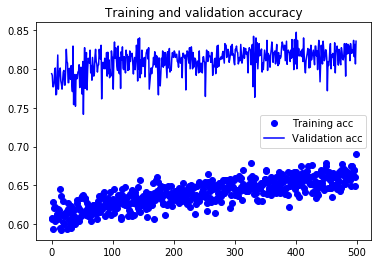

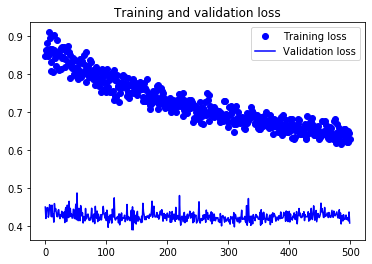

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Finetune model

In [ ]:
# multiply_16
# set 'multiply_16' and following layers trainable
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

/home/the/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
41/41 [==============================] - 31s 750ms/step - loss: 1.3425 - acc: 0.5854 - val_loss: 0.8581 - val_acc: 0.6469
Epoch 2/20
41/41 [==============================] - 6s 156ms/step - loss: 1.1697 - acc: 0.6275 - val_loss: 0.8129 - val_acc: 0.6990
Epoch 3/20
41/41 [==============================] - 7s 159ms/step - loss: 1.2167 - acc: 0.6214 - val_loss: 0.8781 - val_acc: 0.6615
Epoch 4/20
41/41 [==============================] - 6s 157ms/step - loss: 1.1675 - acc: 0.6184 - val_loss: 0.7682 - val_acc: 0.6746
Epoch 5/20
41/41 [==============================] - 7s 160ms/step - loss: 1.2632 - acc: 0.5950 - val_loss: 0.7381 - val_acc: 0.7240
Epoch 6/20
41/41 [==============================] - 6s 154ms/step - loss: 1.1380 - acc: 0.6260 - val_loss: 0.6759 - val_acc: 0.7229
Epoch 7/20
41/41 [==============================] - 7s 159ms/step - loss: 1.1949 - acc: 0.6255 - val_loss: 0.7684 - val_acc: 0.6948
Epoch 8/20
41/41 [==============================] - 6s 158ms/step - loss: 1

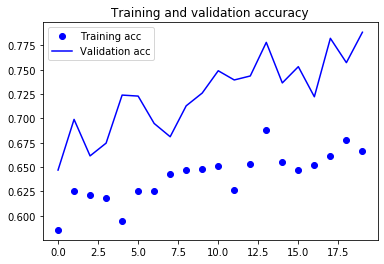

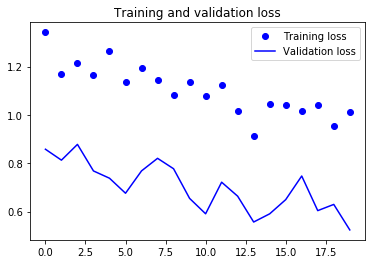

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Try out the model

In [ ]:
cat_img = cat_images[-1]
dog_img= dog_images[-1]

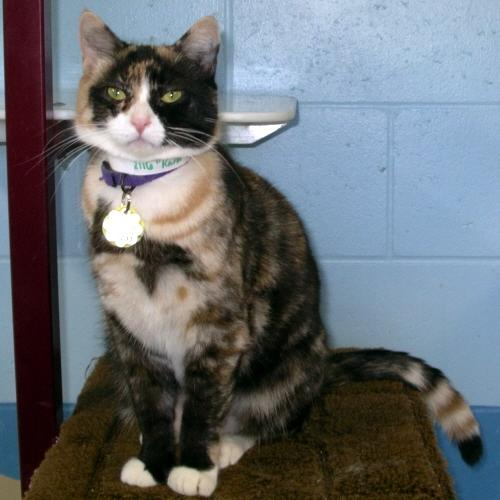

In [ ]:
#loading cat image
Image(filename=cat_img)

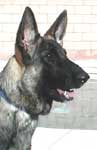

In [ ]:
#loading dog image
Image(filename=dog_img)

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])[0][0]
    if result > 0.5:
        animal = "cat"
    else:
        animal = "dog"
        result = 1 - result
    return animal,result

print(predict_image(cat_img))
print(predict_image(dog_img))

('dog', 0.7994580715894699)
('dog', 0.9645874388515949)
